# Observations of the heat budget of coastal Arctic sea ice under the influence of a river outflow

Master analysis notebook for this Ikaagvik Sikukuun paper.


In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import dask.array as da
import cartopy.crs as ccrs
import cartopy
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import cartopy.feature as cfeature
from osgeo import gdal, osr
import gsw
import windrose
import warnings
import pickle
import tqdm

from matplotlib import cm
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import colorcet as cc
%matplotlib inline

%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Figure 1: Layered Sea Ice Cover Map

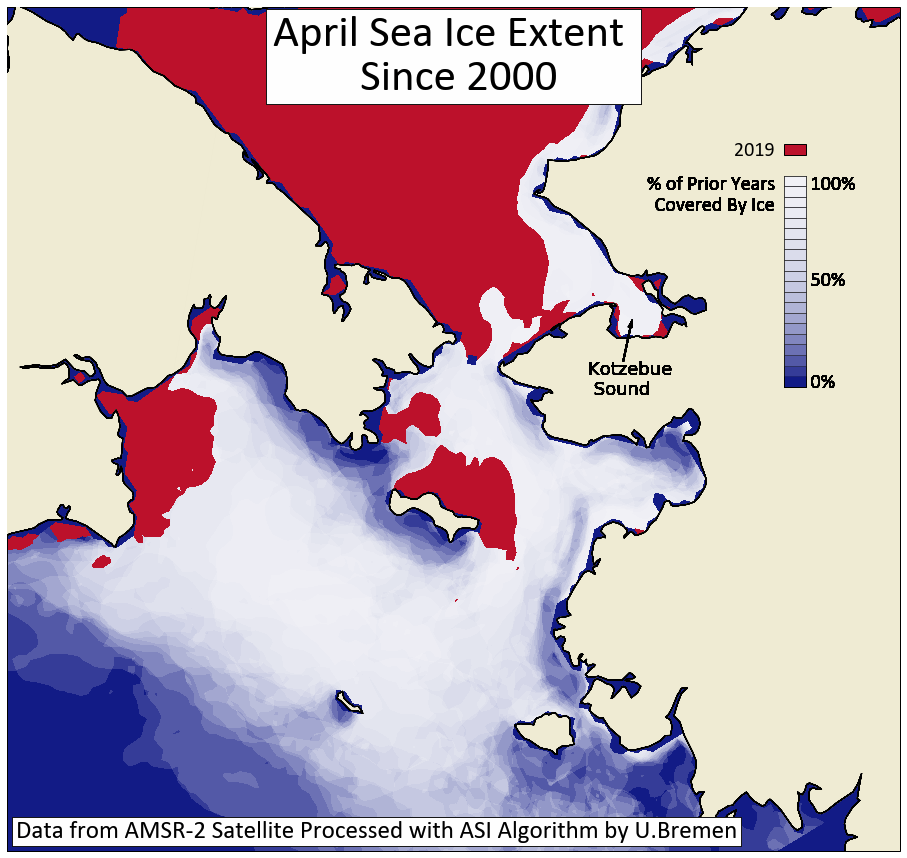

In [3]:
#open datasets of sea ice cover in Bering Strait region for 2000-2018 and 2019 (see Appendix 1 for how I got these datasets)
si = xr.open_dataset('../../Data/Satellite/Sea Ice/ASI_SSMI/si_2000_2018.nc')
si19 = xr.open_dataset('../../Data/Satellite/Sea Ice/ASI_SSMI/si_2019.nc')

#generate map of transparent sea ice cover + 2019 overlaid in red
from Satellite_SeaIce_Toolbox import plot_layered_ice_map
plot_layered_ice_map(si = si, 
                     si19 = si19, 
                     startDay = 91,       #first yearday of April 
                     endDay = 120,        #last yearday of April 
                     thresh = 70,         #minimum sea ice cover threshold to plot as "covered"
                     transparency = 0.15, #transparency of each layer. 0.15 will make a 100% value be about 96% opaque
                     plotflag = 1)        #set to 1 if you want to save figures for every year as it is added

#plt.savefig('Figures/Layered Sea Ice Maps/AprSeaIceExtent_to_2019_v2.png',dpi=300,facecolor='w')

## Figure 2: Sea Ice and SST Monthly Anomalies

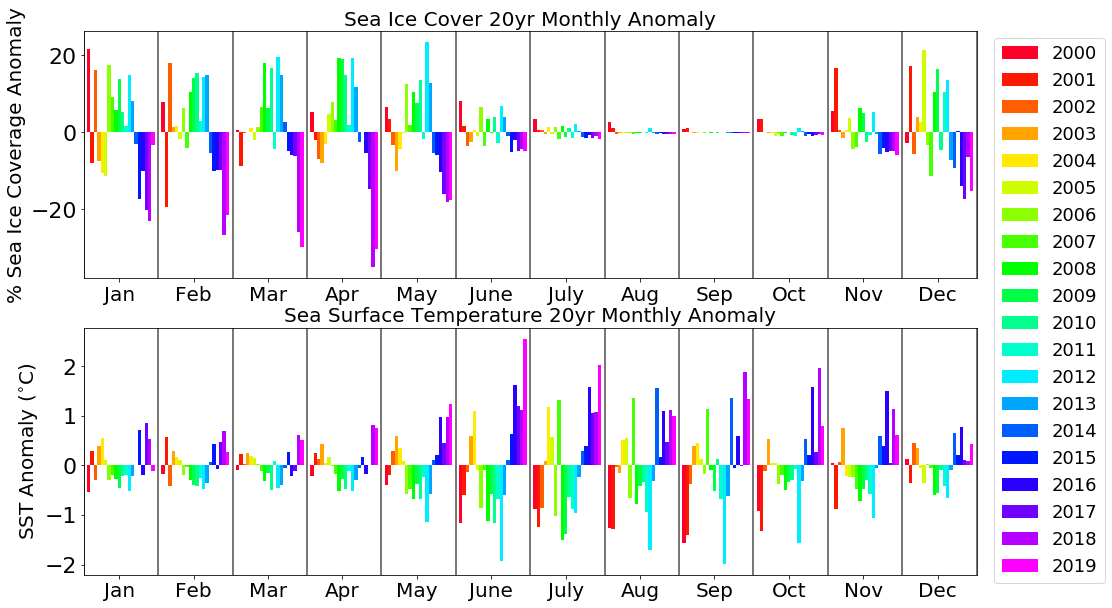

In [99]:
si_mask = xr.open_dataset('../../Data/Satellite/Sea Ice/ASI_SSMI/si_2000_2019_masked.nc')
sst = xr.open_dataset('../../Data/Satellite/SST/oisst_BeringStraitRegion_2000-2019.nc')

from Satellite_SeaIce_Toolbox import plot_monthly_anomalies
plot_monthly_anomalies(si = si_mask, sst = sst)

#plt.savefig('Figures/20Yr_Anomalies_v3.png',dpi=300,bbox_inches='tight')

## Figure 3: Layered Landfast Ice Extent Map

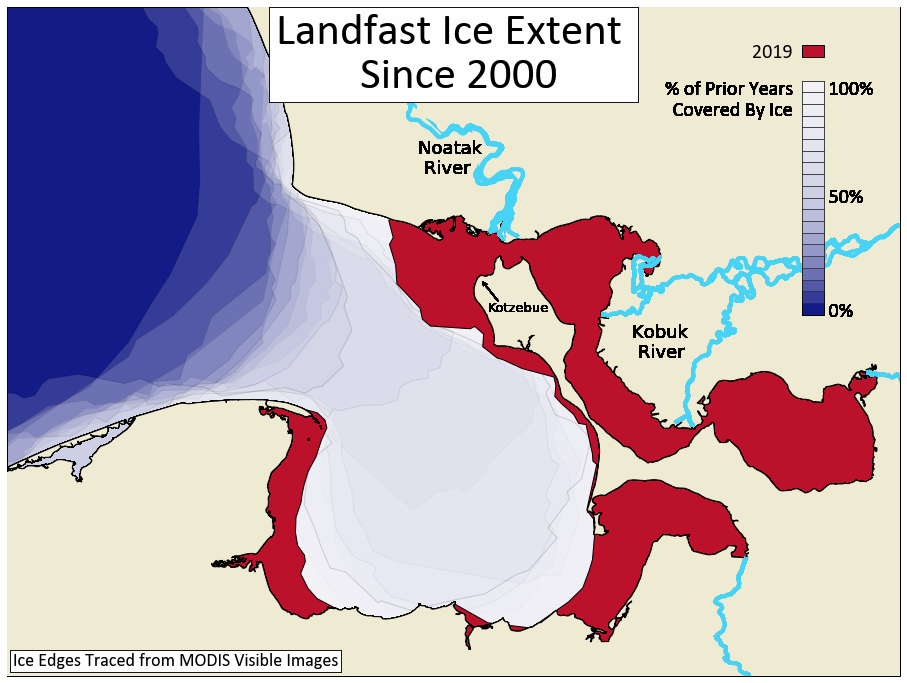

In [5]:
from Satellite_SeaIce_Toolbox import plot_layered_landfast_ice_map
plot_layered_landfast_ice_map(data_folder = '..\QGIS\Landfast Ice', 
                              coastline_path = '../QGIS/GISdata/Coastlines/Alaska_Coast_63360_py_KotzSoundRegion_WGS84.shp', 
                              river_path = '../QGIS/GISdata/Rivers/Major_Rivers_WGS84.shp', 
                              transparency = 0.15, 
                              xmin = -165.4, 
                              xmax = -160.1, 
                              ymin = 65.9, 
                              ymax = 67.55,
                              plotflag = 1)

#plt.savefig(f'Figures/Layered Landfast Ice Maps/LandfastIce_to_2019_v2.png',dpi=300,facecolor='w')

## Figure 4: Satellite View of Kotzebue Sound Breakup


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


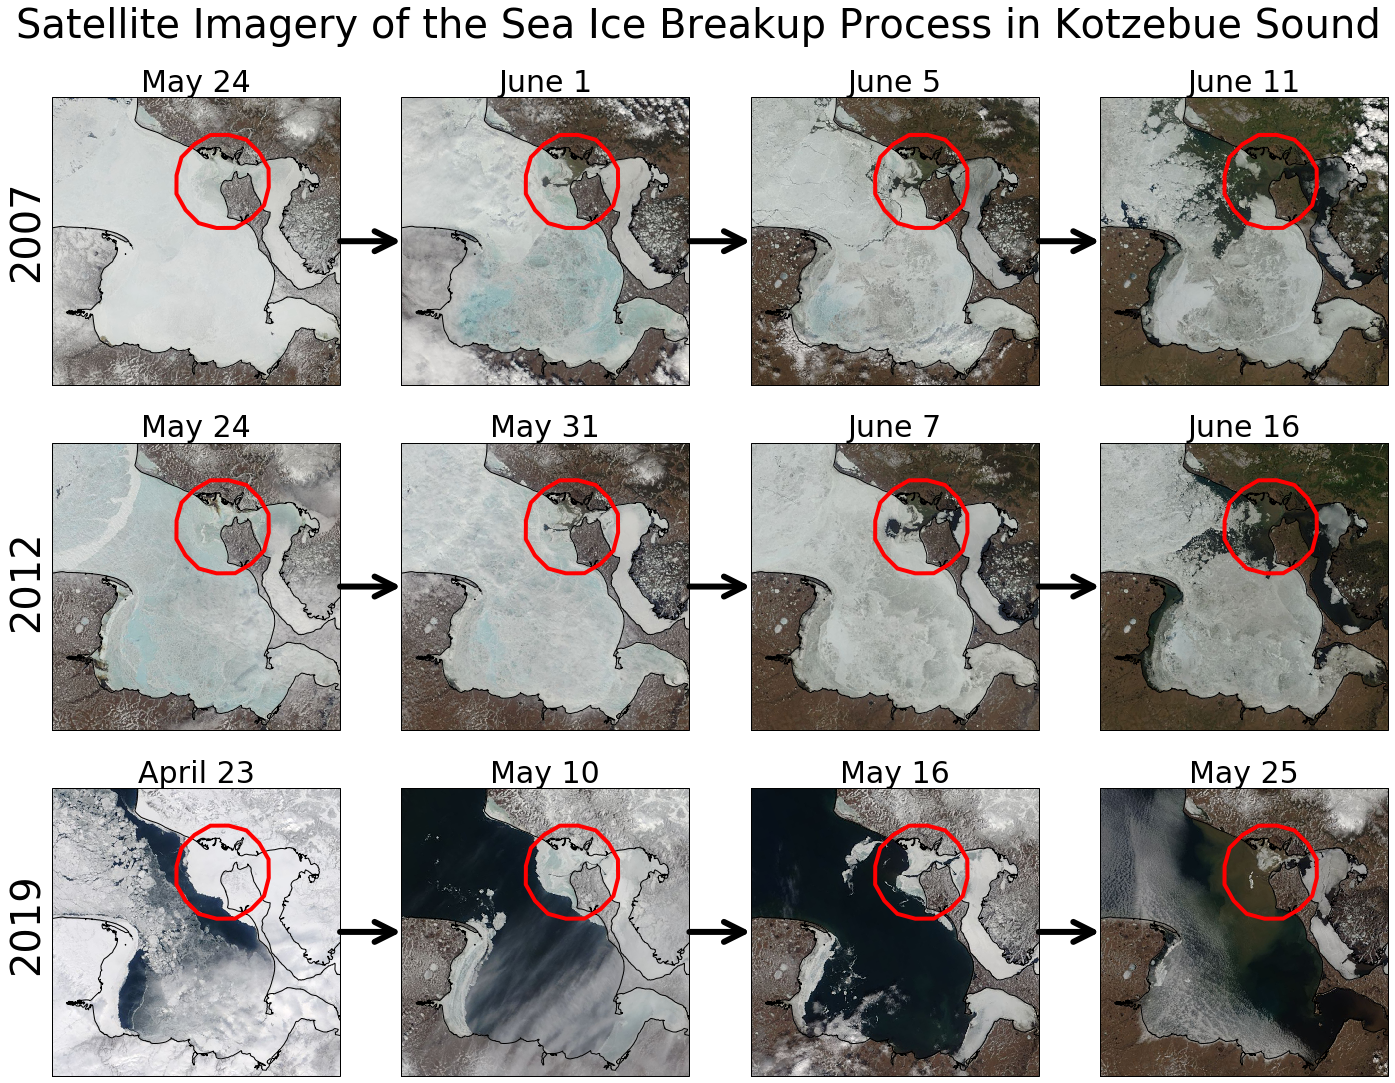

In [26]:
%load_ext autoreload
%autoreload

paths_2007 = ['../../Data/Satellite/Visible Imagery/MODIS_KotzSound/2007/KotzSound_20070524.tif',
              '../../Data/Satellite/Visible Imagery/MODIS_KotzSound/2007/KotzSound_20070601.tif',
              '../../Data/Satellite/Visible Imagery/MODIS_KotzSound/2007/KotzSound_20070605.tif',
              '../../Data/Satellite/Visible Imagery/MODIS_KotzSound/2007/KotzSound_20070611.tif']
paths_2012 = ['../../Data/Satellite/Visible Imagery/MODIS_KotzSound/2012/KotzSound_20120524.tif',
              '../../Data/Satellite/Visible Imagery/MODIS_KotzSound/2012/KotzSound_20120531.tif',
              '../../Data/Satellite/Visible Imagery/MODIS_KotzSound/2012/KotzSound_20120607.tif',
              '../../Data/Satellite/Visible Imagery/MODIS_KotzSound/2012/KotzSound_20120616.tif']
paths_2019 = ['../../Data/Satellite/Visible Imagery/MODIS_KotzSound/2019/KotzSound_20190423.tif',
              '../../Data/Satellite/Visible Imagery/MODIS_KotzSound/2019/KotzSound_20190510.tif',
              '../../Data/Satellite/Visible Imagery/MODIS_KotzSound/2019/KotzSound_20190516.tif',
              '../../Data/Satellite/Visible Imagery/MODIS_KotzSound/2019/KotzSound_20190525.tif']

coastline_path = '../QGIS/GISdata/Coastlines/Alaska_Coast_63360_py_KotzSoundRegion_WGS84.shp'

%autoreload
from Satellite_SeaIce_Toolbox import plot_breakup_images
plot_breakup_images(paths_2007, paths_2012, paths_2019, coastline_path, 
                    lon_min_MOD = -164.3, 
                    lon_max_MOD = -161.3, 
                    lat_min_MOD = 66, 
                    lat_max_MOD = 67.2, 
                    fontsz = 30,
                    figsz = (24,18))

#plt.savefig('./Figures/Breakup_Images_v3.png',dpi=300)

## Figure 5: Measurement Stations in Kotzebue Sound

(made in powerpoint)

<img src='Locations and Measurements v3.png'>

## Figure 6: Overview of ITO Measurements

In [13]:
#----Declare Variables----
lat, lon = 66.8968, -162.6139
start, end = pd.datetime(2019,1,7,22,45,0), pd.datetime(2019,4,1,20,0,0)

#----Load QC'd Data-------
aqd2dir = xr.open_dataset("../Sea Ice Station & OBT/Pickles/aquadopp_currents.nc")
aqd2dir = aqd2dir.where(aqd2dir.bindepth>1)
aqdXr = xr.open_dataset("../Sea Ice Station & OBT/aquadopp_currents_real.nc")
tempsXr = xr.open_dataarray("../Sea Ice Station & OBT/Pickles/temperature_uninterpolated.nc")
tempsXrInterp = xr.open_dataarray("../Sea Ice Station & OBT/Pickles/temperature_profile.nc")
rbr = pickle.load( open( "../Sea Ice Station & OBT/Pickles/concerto_10minResample.p", "rb" ))
rbr = rbr[1:] #to line times up with tempsXr
maximet = pickle.load( open( "../Sea Ice Station & OBT/Pickles/maximet_selectedvars_10minResample_QCv1.p", "rb" ) )
cnr_rsmpl = pickle.load( open( "../Sea Ice Station & OBT/Pickles/cnr_10minResample.p", "rb" ))
mbs_mean = pickle.load( open( "../Sea Ice Station & OBT/Pickles/mbs_channel_meanValues.p", "rb" ))
fws_rsmpl = pickle.load( open( "../Sea Ice Station & OBT/Pickles/fws_10minResample.p", "rb" ))
tt = pd.read_pickle('../Sea Ice Station & OBT/Pickles/tinytag.p')

In [32]:
#rbr.to_csv('../Sea Ice Station & OBT/Pickles/concerto_10min.csv')
#maximet.to_csv('../Sea Ice Station & OBT/Pickles/maximet_10min.csv')
#cnr_rsmpl.to_csv('../Sea Ice Station & OBT/Pickles/cnr_10min.csv')
#mbs_mean.to_csv('../Sea Ice Station & OBT/Pickles/massBalanceMeanValues.csv')
#fws_rsmpl.to_csv('../Sea Ice Station & OBT/Pickles/fws_10min.csv')

In [30]:
pd.read_csv('../Sea Ice Station & OBT/Pickles/fws_10min.csv',index_col=0,parse_dates=True)

RecordNum          Rs     T_cmp22     Rl_corr         Rl  \
DateTime                                                                        
2019-01-05 19:40:00  4017311.0   -1.998288  253.376856  163.067867 -70.427870   
2019-01-05 19:50:00  4017416.5   -2.146472  253.164983  162.834914 -69.950697   
2019-01-05 20:00:00  4017536.5   -1.911512  252.370068  161.869006 -68.060589   
2019-01-05 20:10:00  4017656.5   -1.580607  251.764249  160.608263 -67.059919   
2019-01-05 20:20:00  4017776.5   -1.254967  251.154882  159.856821 -65.540547   
...                        ...         ...         ...         ...        ...   
2019-04-30 15:50:00  6001736.5  130.687176  276.087092  249.103892 -79.633545   
2019-04-30 16:00:00  6001856.5  148.061585  276.105838  249.419004 -79.409308   
2019-04-30 16:10:00  6001976.5  165.833066  276.257962  249.683989 -79.897770   
2019-04-30 16:20:00  6002096.5  181.932009  276.293846  249.998425 -79.729827   
2019-04-30 16:30:00  6002199.0  196.569812  276.444740  250.922280 -79.586999   

                         T_cgr4  PanelTemp   BattVolt  
DateTime                                               
2019-01-05 19:40:00  253.322612 -19.681665  11.823216  
2019-01-05 19:50:00  253.129588 -19.670026  11.823385  
2019-01-05 20:00:00  252.349488 -19.700657  11.823128  
2019-01-05 20:10:00  251.726876 -19.786797  11.822597  
2019-01-05 20:20:00  251.096611 -19.918246  11.822438  
...                         ...        ...        ...  
2019-04-30 15:50:00  275.941181   4.427949  11.864420  
2019-04-30 16:00:00  275.960253   4.727137  11.865120  
2019-04-30 16:10:00  276.118182   5.025140  11.865440  
2019-04-30 16:20:00  276.148858   5.318450  11.866190  
2019-04-30 16:30:00  276.312240   5.549610  11.866130  

[16542 rows x 8 columns]

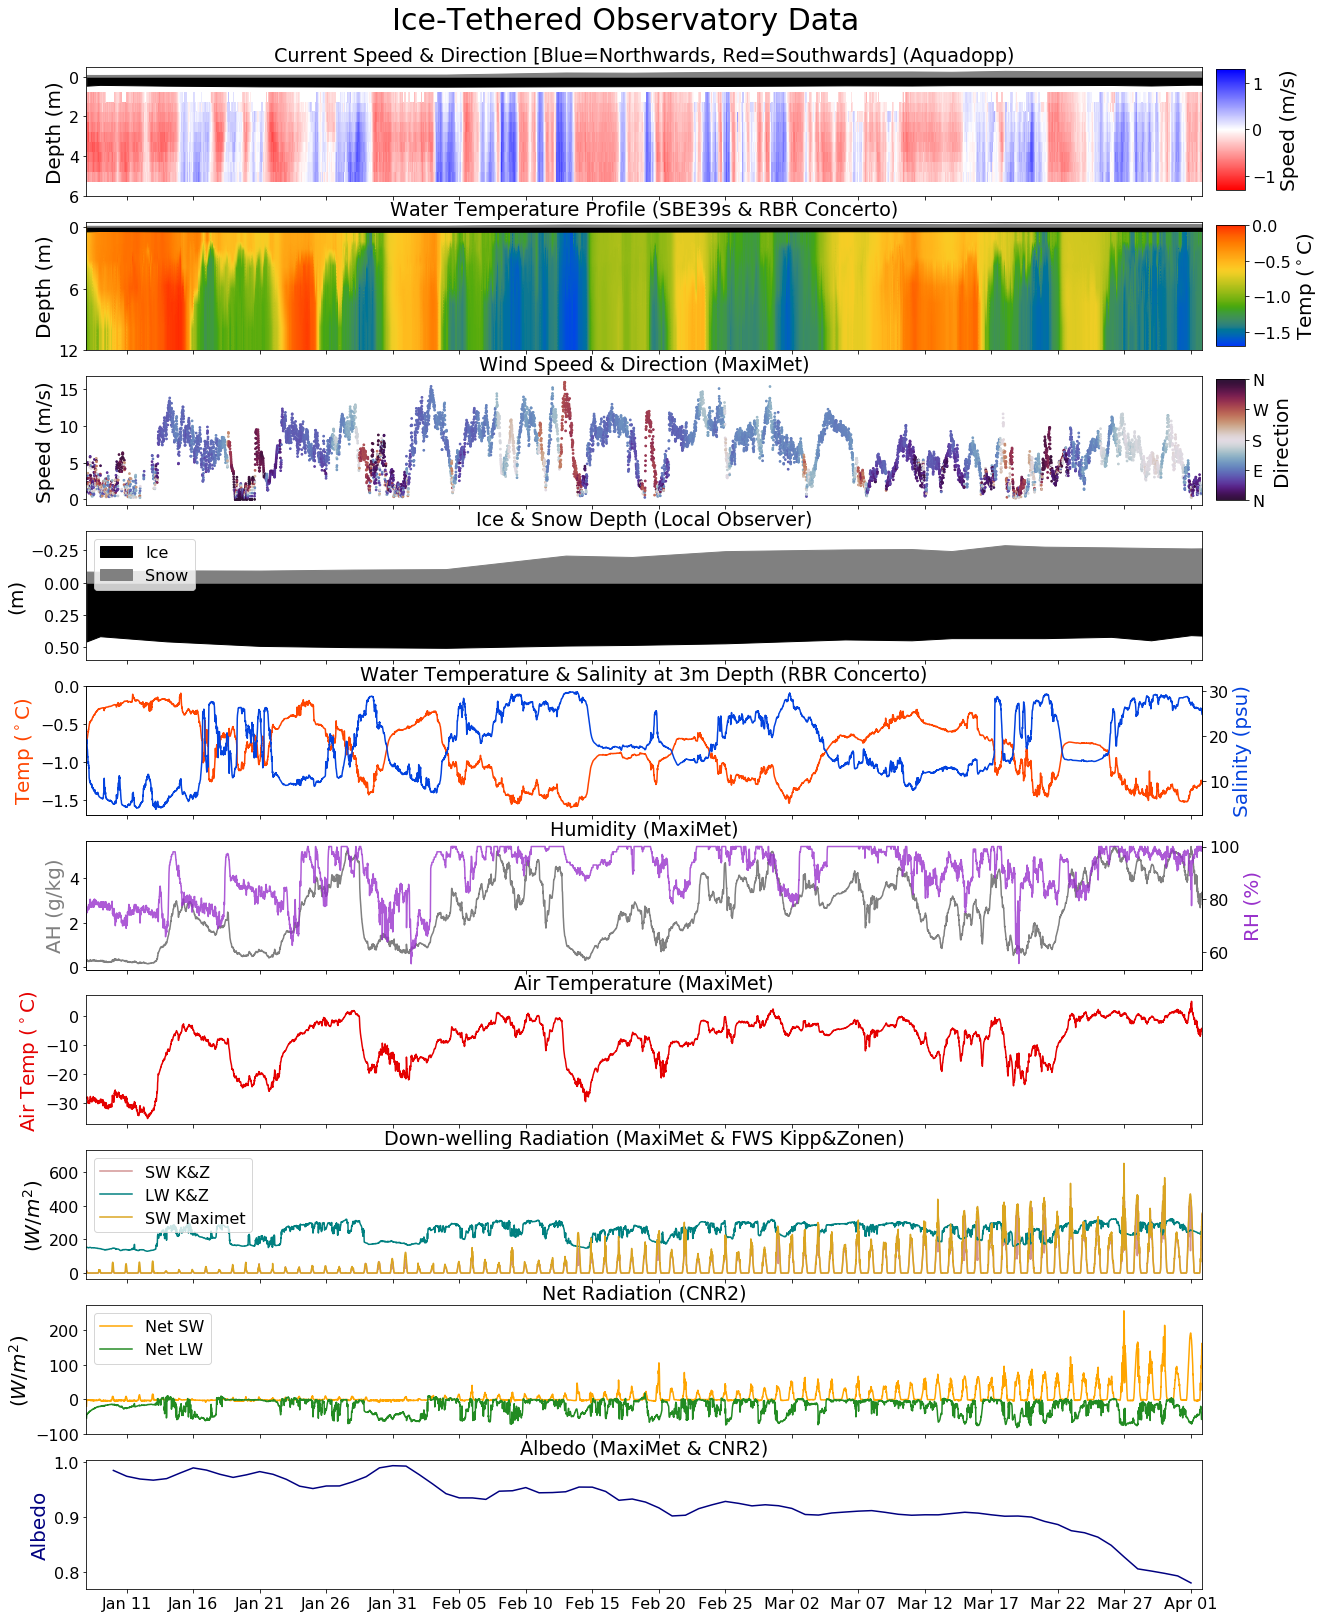

In [5]:
from IkSi_Analysis_Toolbox import plot_overview_timeseries
plot_overview_timeseries(start, end, aqd2dir, mbs_mean, tempsXrInterp, rbr, maximet, fws_rsmpl, cnr_rsmpl)

#plt.savefig('Figures/OverviewTimeseries_v3.png',dpi=300)

## Figure 7: Flux balances at both interfaces

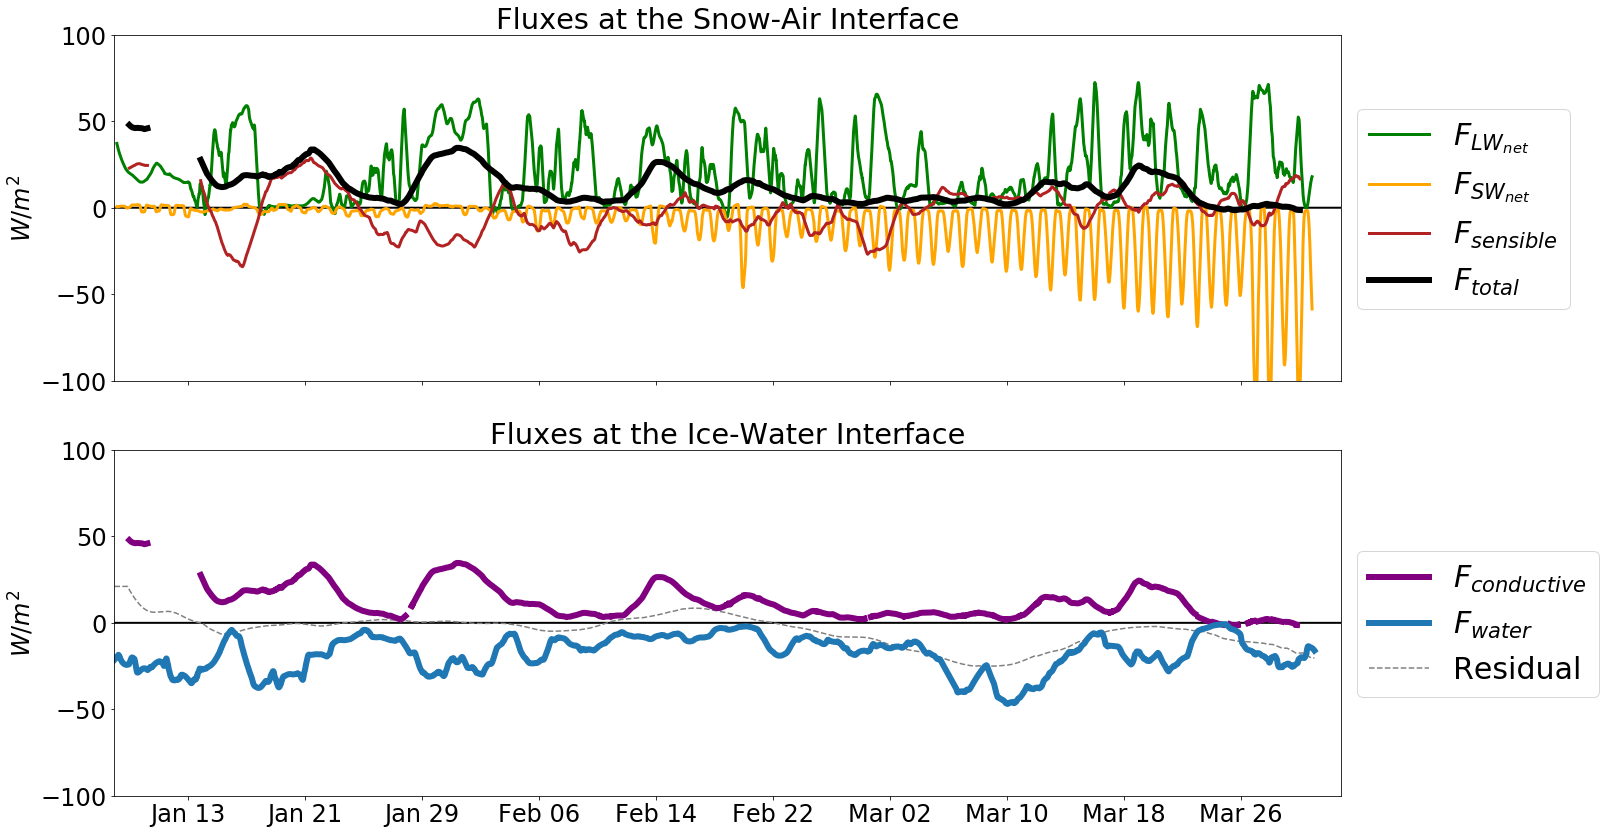

In [9]:
from IkSi_Analysis_Toolbox import calculate_Fw, plot_flux_balances
#calculate ocean-ice heat flux following McPhee '92
Fw_92 = calculate_Fw(deltaT, ustar, rbr_rsmpl, lon, lat)
#Update mass balance data to reflect ice and snow thickness treating flooded snow as ice
mbs_mean = pd.read_csv('../../Data/Sea Ice Station/MassBalance/mbs_mean_withflooding.csv',index_col=0,parse_dates=True,usecols=[0,1,2])
#calculate and plot flux balances at both boundaries
plot_flux_balances(mbs_mean, maximet, cnr_rsmpl, rbr_rsmpl, Fw_92)

#plt.savefig('./Figures/Flux Balances v3.png',dpi=300)

## Figure 8: Bi-directional current correlations

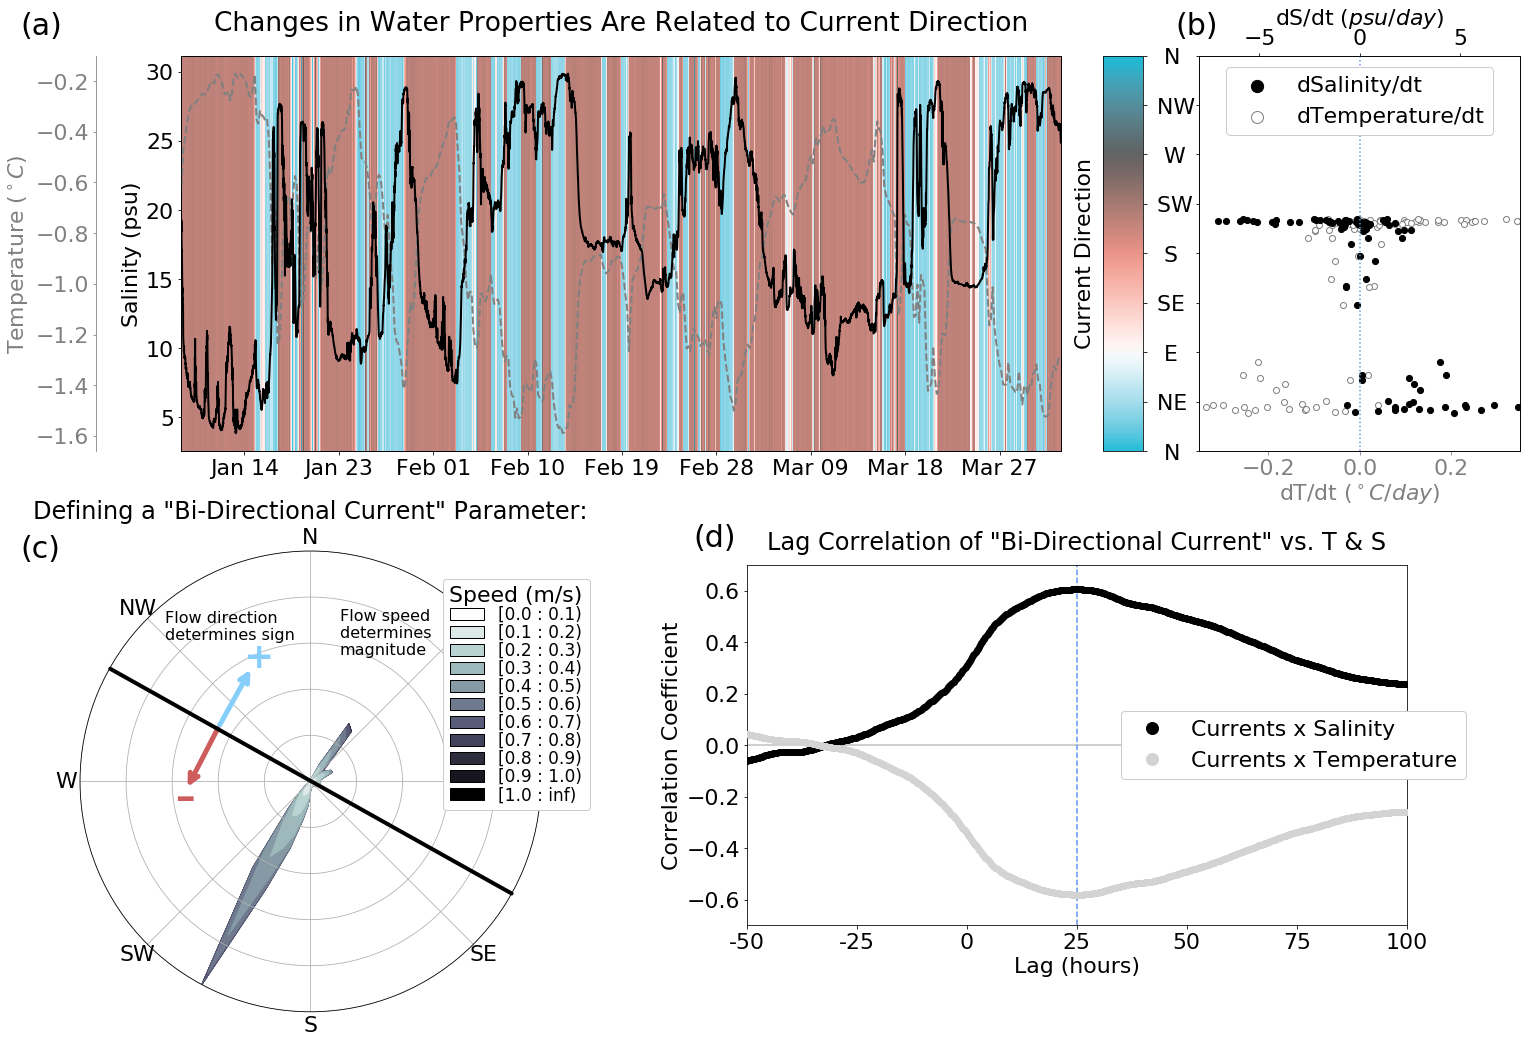

In [25]:
%autoreload
from IkSi_Analysis_Toolbox import currents_vs_TS
currents_vs_TS(rbr,aqdXr,aqd2dir,start,end)

#plt.savefig('Figures/TS_Currents_v2.png',dpi=300)

## Figure 9: $u_{*0}$ and St vs Re

C:\Users\cwitt\Anaconda3\lib\site-packages\xarray\core\nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


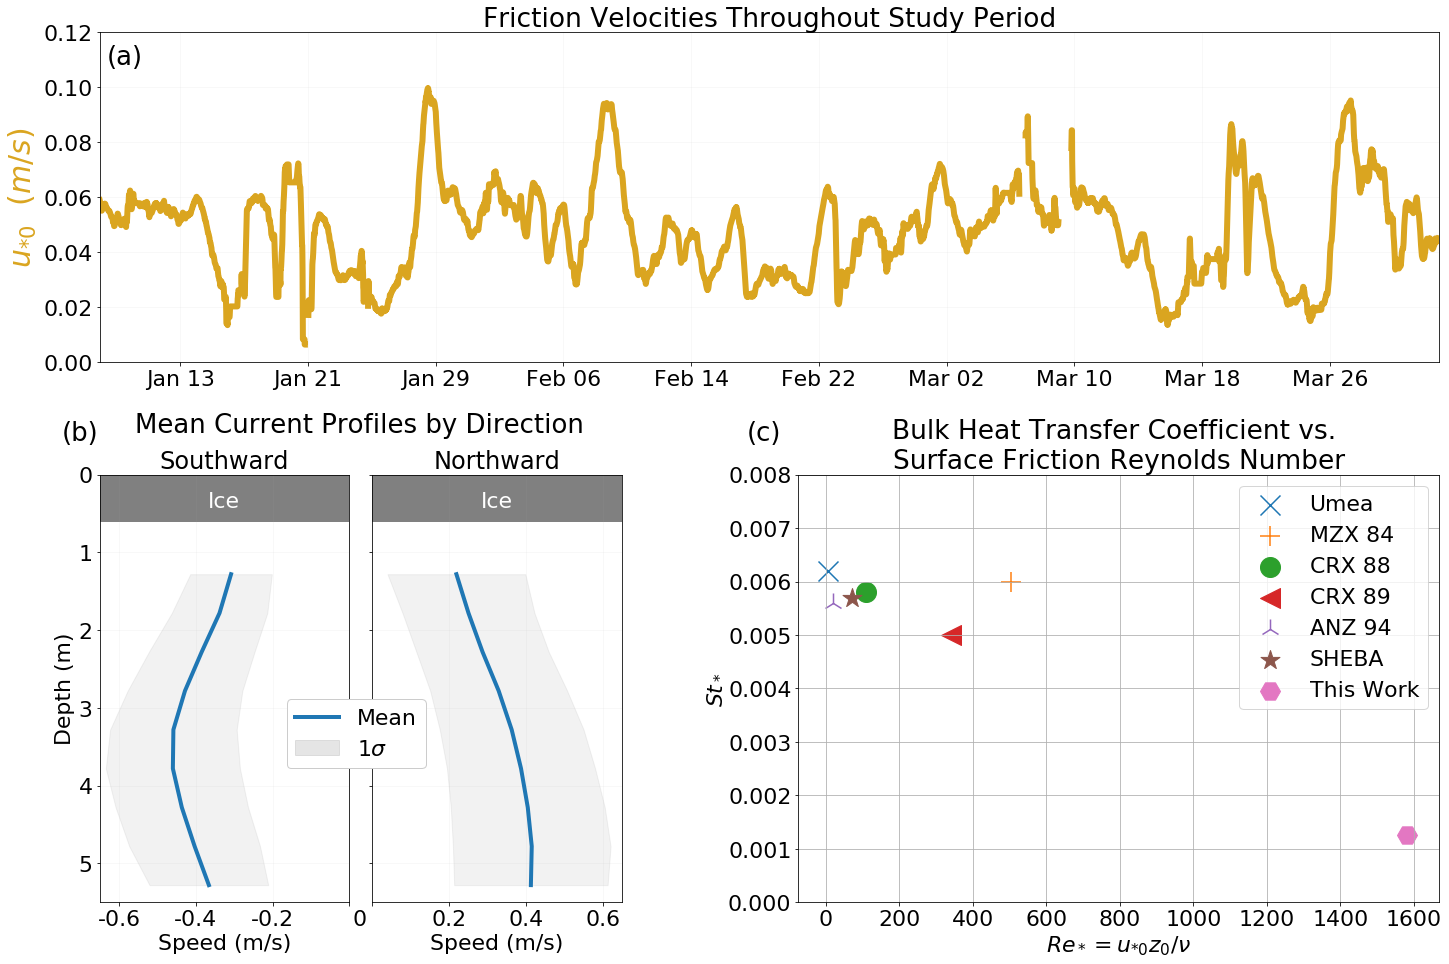

In [7]:
%autoreload
from IkSi_Analysis_Toolbox import calculate_ustar, plot_ustar

roll=4 #number of 15-minute periods to calculate the rolling mean over
ustar = calculate_ustar(aqdXr, roll)
StvRe = pd.read_csv('../../Data/Sea Ice Station/HeatFluxScaling/ReynoldsNumber_vs_StantonNumber.csv',index_col=0)

plot_ustar(ustar,aqd2dir,StvRe,start,end)

#plt.savefig('./Figures/ustar_v3.png',dpi=600)

## Figure 10: Relationship Between Salinity & Departure From Freezing Point

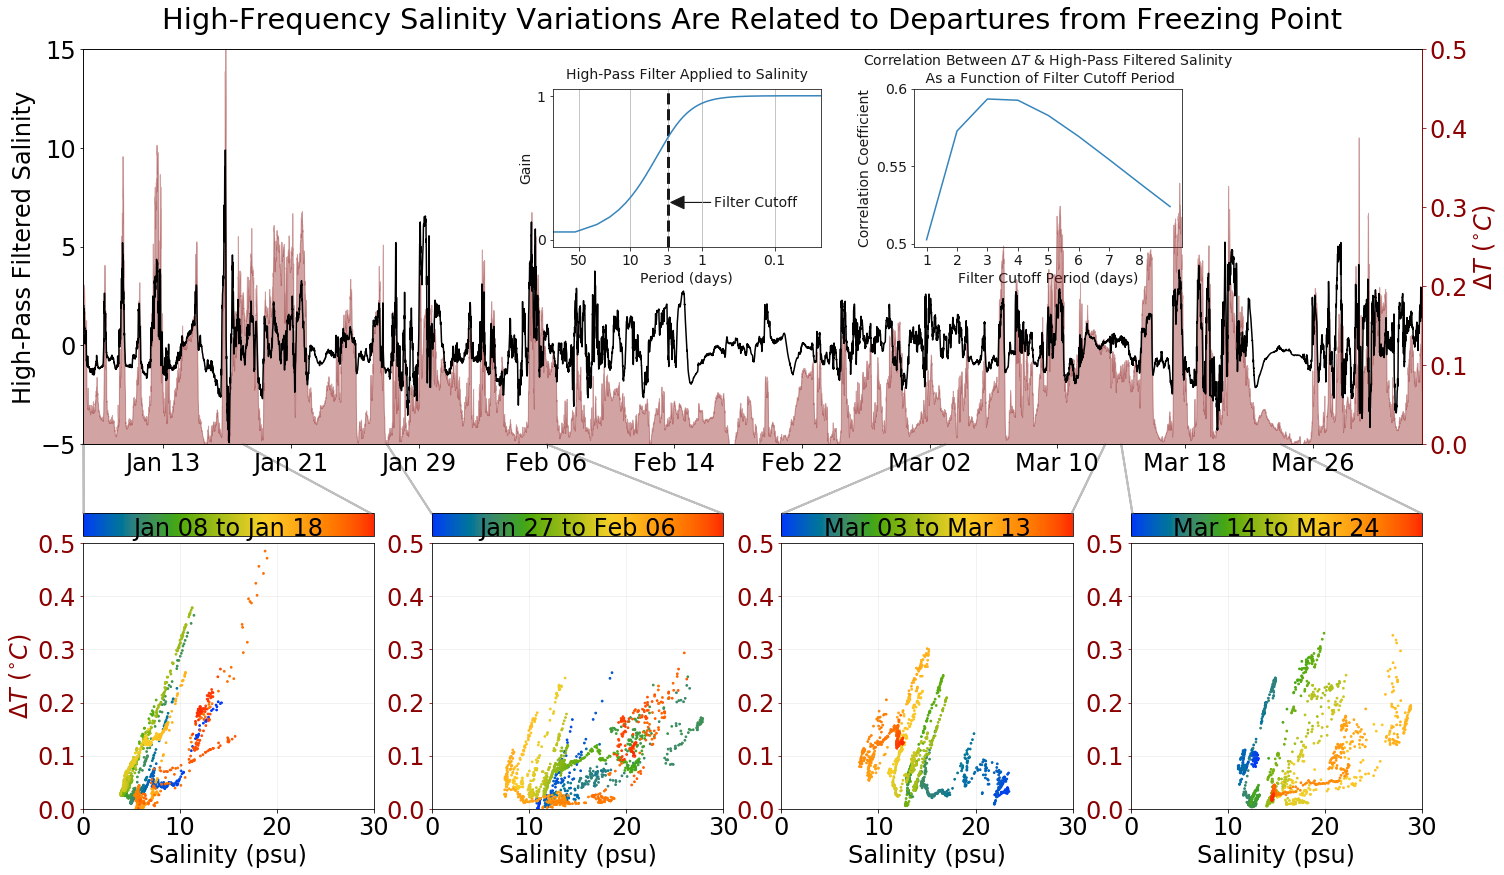

In [8]:
%autoreload
from IkSi_Analysis_Toolbox import calculate_deltaT, plot_filtered_sal_v_deltaT

rbr = calculate_deltaT(rbr, tempsXrInterp)

plt.rcParams.update({'font.size': 24})
plot_filtered_sal_v_deltaT(rbr, start, end)

#plt.savefig('./Figures/Sal_v_dT_v3.png',dpi=300)

## Figure 11: T-S Diagram of fall vs. spring at OBT

In [33]:
#import data
sbeOBT = pd.read_pickle('../../Data/Ocean Bottom Tripod/Pickles/sbe_OBT_2019.p')
sbeOBT18 = pd.read_pickle('../../Data/Ocean Bottom Tripod/Pickles/sbe_OBT_2018.p')

In [35]:
sbeOBT.to_csv('../../Data/Ocean Bottom Tripod/Pickles/sbe_OBT_2019.csv')
sbeOBT18.to_csv('../../Data/Ocean Bottom Tripod/Pickles/sbe_OBT_2018.csv')

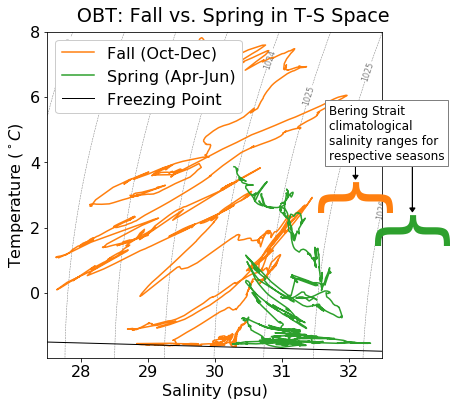

In [10]:
%autoreload

from IkSi_Analysis_Toolbox import plot_OBT_fallVspring_TS
plot_OBT_fallVspring_TS(sbeOBT, 
                        fall_start_18 = pd.datetime(2018,10,15,0,0,0), 
                        fall_end_18 = pd.datetime(2018,12,15,0,0,0), 
                        spring_start_19 = pd.datetime(2019,4,15,0,0,0), 
                        spring_end_19 = pd.datetime(2019,6,15,0,0,0))


#plt.savefig('./Figures/OBT_TS_FallSpring_v2.png',dpi=300,bbox_inches='tight')

## Figure 12: Temperature and Salinity at OBT - Spring and Fall

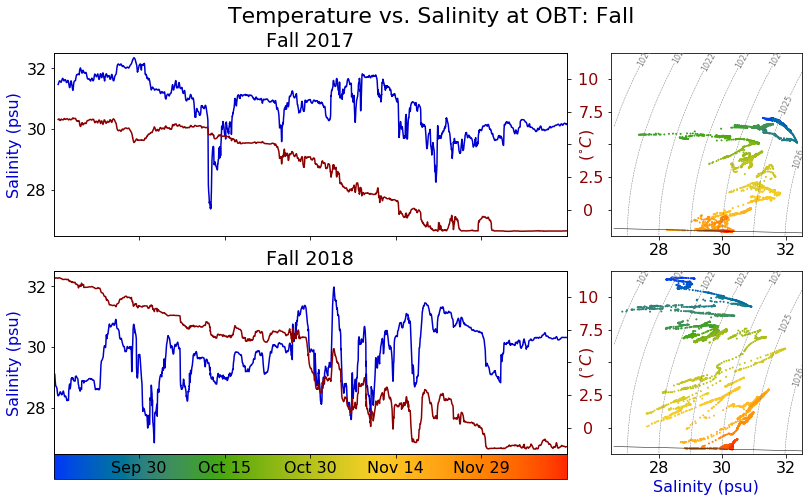

In [11]:
from IkSi_Analysis_Toolbox import plot_OBT_sections
plot_OBT_sections(sbeOBT18, sbeOBT, 
                  start1 = pd.datetime(2017,9,15,0,0,0), end1 = pd.datetime(2017,12,15,0,0,0),
                  start2 = pd.datetime(2018,9,15,0,0,0), end2 = pd.datetime(2018,12,15,0,0,0),
                  sal_lims = [26.5,32.5], 
                  temp_lims = [-2, 12], temp_ticks = [0,2.5,5,7.5,10], temp_tick_labels = ['0  ','2.5','','7.5','10 '],
                  nticks = 5, 
                  title1 = 'Fall 2017',
                  title2 = 'Fall 2018',
                  supTitle = 'Temperature vs. Salinity at OBT: Fall')

#plt.savefig('./Figures/OBT_TS_Fall_v1.png',dpi=300)

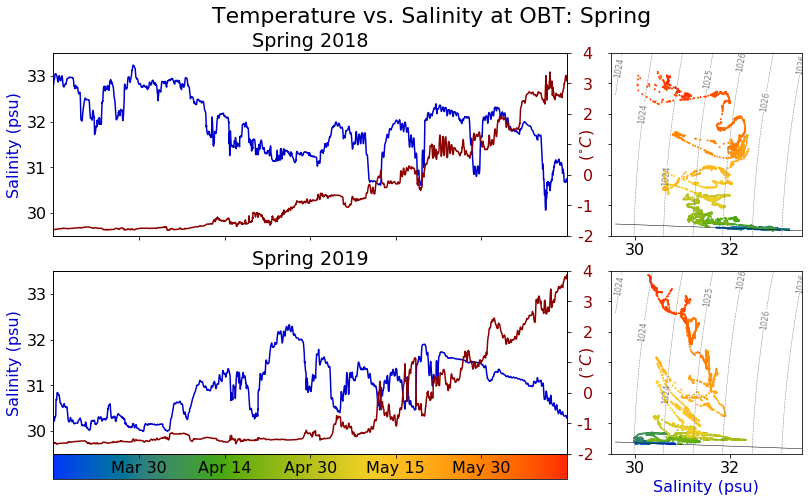

In [12]:
from IkSi_Analysis_Toolbox import plot_OBT_sections
plot_OBT_sections(sbeOBT18, sbeOBT, 
                  start1 = pd.datetime(2018,3,15,0,0,0), end1 = pd.datetime(2018,6,15,0,0,0),
                  start2 = pd.datetime(2019,3,15,0,0,0), end2 = pd.datetime(2019,6,15,0,0,0),
                  sal_lims = [29.5,33.5], 
                  temp_lims = [-2, 4], temp_ticks = [-2,-1,0,1,2,3,4], temp_tick_labels = ['-2  ','-1  ','0  ','','2  ','3  ','4  '],
                  nticks = 5, 
                  title1 = 'Spring 2018',
                  title2 = 'Spring 2019',
                  supTitle = 'Temperature vs. Salinity at OBT: Spring')

#plt.savefig('./Figures/OBT_TS_Spring_v1.png',dpi=300)

# Appendix 1: Satellite Importing and Subsetting

1.1 - These codes pull data from externally hosted OpenDAP servers, so they can take a long time to execute and they will only work insofar as those servers are still hosted in the same manner. I've left the cell as raw text rather than code to avoid accidentally executing it, but they show how the data got to where it is in the main analysis.

1.2 - creating a land mask for the sea ice data so that we can do meaningful computation on it (right now, both land and zero-ice-cover are NaNs, but we need zero-ice-cover to be 0 and land to be NaN)

In [53]:
from Satellite_SeaIce_Toolbox import subset_ssmi
#open the same data used above
si = xr.open_mfdataset(['../../Data/Satellite/Sea Ice/ASI_SSMI/si_2000_2018.nc',
                        '../../Data/Satellite/Sea Ice/ASI_SSMI/si_2019.nc'])

#chop off the top part, which made the edge of the map look pretty but isn't within the bounds of the map
lon_min_bering, lon_max_bering = 175, -150
lat_min_bering, lat_max_bering = 58, 75-4.5
xmin_ssmi, xmax_ssmi = 0, 200
ymin_ssmi, ymax_ssmi = 0, 700

si_sub = subset_ssmi(si, lat_min_bering, lat_max_bering, lon_min_bering, lon_max_bering,
                     xmin_ssmi, xmax_ssmi, ymin_ssmi, ymax_ssmi)

#we need to account for the possibility of NaN meaning both zero ice and land by creating a landmask from the day when there is a minimum number of NaNs
#find the time when there is a minimum number of NaN values
nanCounts = np.isnan(si_sub.sea_ice_area_fraction).sum(dim={'x','y'})
maskTime = si_sub.where(nanCounts==nanCounts.min(),drop=True).squeeze().time.values
#create land mask using data from this time
mask_ocean = 2 * np.ones((si_sub.dims['y'], si_sub.dims['x'])) * np.isfinite(si_sub.land.sel(time=maskTime))  
mask_land = 1 * np.ones((si_sub.dims['y'], si_sub.dims['x'])) * np.isnan(si_sub.land.sel(time=maskTime))  
mask_array = mask_ocean + mask_land
#add mask to dataArray
si_sub.coords['mask'] = (('y','x'),mask_array)
si_sub.coords['mask'].attrs['Description'] = '2 for ocean, 1 for land'
#replace all nans with zeros in sea_ice_area_fraction, then re-nan everywhere that isn't ocean
si_sub['sea_ice_area_fraction'] = si_sub.sea_ice_area_fraction.fillna(0).where(si_sub.mask==2)

#save new netcdf file
si_sub.to_netcdf('../../Data/Satellite/Sea Ice/ASI_SSMI/si_2000_2019_masked.nc')

C:\ProgramData\Anaconda3\lib\site-packages\dask\core.py:137: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
C:\ProgramData\Anaconda3\lib\site-packages\dask\core.py:137: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
C:\ProgramData\Anaconda3\lib\site-packages\dask\core.py:137: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


1.3 - Importing Nasa OISST Reynolds Composite Sea Ice Product

In [ ]:
#pathh = 'https://www.ncei.noaa.gov/thredds/dodsC/OisstBase/NetCDF/V2.1/AVHRR/200005/oisst-avhrr-v02r01.20000501.nc'
reysst = xr.open_dataset('https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/NCEI/AVHRR_OI/v2/2000/001/20000101120000-NCEI-L4_GHRSST-SSTblend-AVHRR_OI-GLOB-v02.0-fv02.0.nc')  

In [ ]:
#define spatial limits
lat_min, lat_max = 65.479474, 68.708048
lon_min, lon_max = -169.259880, -160.007140

#define timeframe
start_date = pd.datetime(2000,1,1)
end_date = pd.datetime(2000,1,31)
ddts = pd.date_range(start=start_date,end=end_date) #"daily-date-times"

data_days = []
#----------------------------------------------------------------------------------------#
for day in ddts:
    yearmonth = day.strftime('%Y%m')
    yearmonthday = day.strftime('%Y%m%d')
    #pathh = f'http://www.ncei.noaa.gov/thredds/dodsC/OisstBase/NetCDF/AVHRR/{yearmonth}/avhrr-only-v2.{yearmonthday}.nc'
    pathh = f'https://www.ncei.noaa.gov/thredds/dodsC/OisstBase/NetCDF/V2.1/AVHRR/{yearmonth}/oisst-avhrr-v02r01.{yearmonthday}.nc'    
    #open that day's data
    reysst = xr.open_dataset(pathh)
    
    #slice data and plot into map
    reysst.sst.sel(lat=slice(lat_min,lat_max), 
                   lon=slice((lon_min+360)%360, (lon_max+360)%360))
    
    data_days.append(reysst)
    
sst = xr.auto_combine(data_days)
sst